In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import pandas as pd

from final_project import loader, builder, models, plots
from final_project.models import ModelENUM
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
df = loader.get_df(all_files=True)
df = df[df['Origin'] == 'BOS']
df = df[[
    'DistanceGroup',
    'DayofMonth',
    'Month',
    'Year',
    'Duplicate',
    'ArrDel15',
    'DistanceGroup',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'Operating_Airline',
    'Dest'
]]
df = builder.encodeFrame(df)

delay_df = df[df['ArrDel15'] > 0.5].sample(n=2000)
on_time_df = df[df['ArrDel15'] <= 0.5].sample(n=8000)
sample_df = pd.concat([delay_df, on_time_df], ignore_index=True)


x = sample_df.drop(columns=['ArrDel15'])
y = sample_df[['ArrDel15']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=150)
print(df.shape)

(512522, 122)


In [6]:
svm_pipeline = models.get_pipeline(ModelENUM.SVM)
param_grid = [
    models.get_svm_param(gamma=['auto', 'scale'], c_list=[1, 10], coef0=[0, 1, 2], degree=[2,3], kernel=['linear', 'poly'], max_iter=[5000], cache_size=[8000])
    # models.get_svm_param(gamma=['auto', 'scale'], c_list=[.001, .01, 1, 10], coef0=[0, 1, 2], kernel=['linear', 'poly', 'rbf'], max_iter=[10000])
    # models.get_svm_param(gamma=[2, 3, 4, 'scale', 'auto'], c_list=[1e-2, 1e-1, 1e1, 1e2], coef0=[0, 1, 2], kernel=['linear', 'poly', 'rbf'])
    # models.get_svm_param(gamma=[2], c_list=[1e-2], coef0=[1], kernel=['linear'])
]
grid_search = models.get_grid_search_cv(
    pipeline=svm_pipeline, param_grid=param_grid, cv=3, n_jobs=40
)

In [7]:
svm_model = grid_search.fit(x_train, y_train.to_numpy().ravel())

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 2/3; 2/72] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 4/72] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 1/3; 4/72] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 3/3; 2/72] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 3/3; 1/72] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True[CV 1/3; 1/72] START svm__C=0.001, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True

[CV 3/3; 4/72] START svm__C=0.001,

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 35/72] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.4min
[CV 1/3; 51/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 2/3; 35/72] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.5min
[CV 2/3; 51/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 2/3; 37/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 2.4min
[CV 3/3; 51/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 3/3; 37/72] END svm_

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 35/72] END svm__C=0.01, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 3.0min
[CV 2/3; 53/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 1/3; 39/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.7min
[CV 3/3; 53/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 39/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.9min
[CV 1/3; 54/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 2/3; 41/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.011 total time= 2.5min
[CV 2/3; 54/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 41/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.011 total time= 2.6min
[CV 3/3; 54/72] START svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 3/3; 43/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.134 total time= 2.0min
[CV 1/3; 55/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 1/3; 43/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 2.1min
[CV 2/3; 55/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 41/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.015 total time= 2.6min
[CV 3/3; 55/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 1/3; 46/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 1.8min
[CV 1/3; 56/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 44/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.1min
[CV 2/3; 56/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 3/3; 44/72] END sv

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 47/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.179 total time= 2.1min
[CV 1/3; 59/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 52/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 1.5min
[CV 2/3; 59/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 3/3; 49/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.134 total time= 2.0min
[CV 3/3; 59/72] START svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 49/72] END

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 48/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.5min
[CV 3/3; 61/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 52/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 2.0min
[CV 1/3; 62/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 48/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.6min
[CV 2/3; 62/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 3/3; 52/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.134 total time= 2.0min
[CV 3/3; 62/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 42/72] END svm__C=1, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 3.4min
[CV 1/3; 63/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 1/3; 47/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.186 total time= 2.7min
[CV 2/3; 63/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 50/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.4min
[CV 3/3; 63/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 2/3; 50/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.4min
[CV 1/3; 64/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 47/72] END svm__C=1, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.217 total time= 2.9min
[CV 2/3; 64/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 2/3; 51/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.3min
[CV 3/3; 64/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 3/3; 50/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.5min
[CV 1/3; 65/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 1/3; 51/72] END s

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 51/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 2.5min
[CV 1/3; 66/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 1/3; 53/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.365 total time= 2.4min
[CV 2/3; 66/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 1/3; 56/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 1.5min
[CV 3/3; 66/72] START svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 2/3; 56/72] END svm__C=

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 53/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.351 total time= 2.6min
[CV 3/3; 67/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 3/3; 53/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.417 total time= 2.7min
[CV 1/3; 68/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 55/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.514 total time= 2.2min
[CV 2/3; 68/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 3/3; 55/72] END s

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-pro

[CV 2/3; 58/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.514 total time= 2.4min
[CV 1/3; 70/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True
[CV 1/3; 59/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.231 total time= 2.2min
[CV 2/3; 70/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 54/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.011 total time= 2.8min
[CV 3/3; 70/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 59/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.263 total time= 2.3min
[CV 1/3; 71/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 1/3; 54/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 3.1min
[CV 2/3; 71/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 54/72] END svm__C=1, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.000 total time= 3.0min
[CV 3/3; 71/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True
[CV 2/3; 57/72] END svm

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 61/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.582 total time= 2.2min
[CV 2/3; 72/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True
[CV 2/3; 61/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.514 total time= 2.4min
[CV 3/3; 72/72] START svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 59/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.208 total time= 2.7min
[CV 3/3; 57/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.015 total time= 3.0min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 64/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.505 total time= 2.2min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 60/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.206 total time= 2.9min
[CV 1/3; 61/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.505 total time= 2.8min
[CV 2/3; 60/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.191 total time= 2.8min
[CV 1/3; 57/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 3.4min
[CV 1/3; 62/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.011 total time= 2.5min
[CV 3/3; 60/72] END svm__C=10, svm__cache_size=4000, svm__coef0=0, svm__gamma=scale, svm__kernel=rbf, svm__ma

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 62/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.030 total time= 2.5min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 65/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.545 total time= 2.3min
[CV 2/3; 62/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.011 total time= 2.6min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 67/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.514 total time= 1.9min
[CV 3/3; 65/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.572 total time= 2.3min
[CV 2/3; 64/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.514 total time= 2.4min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 64/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.582 total time= 2.5min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 65/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.512 total time= 2.5min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 67/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.505 total time= 2.2min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 63/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.8min
[CV 1/3; 63/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 2.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 66/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.191 total time= 2.3min
[CV 3/3; 66/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.228 total time= 2.3min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 66/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.206 total time= 2.4min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 68/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 1.8min
[CV 3/3; 63/72] END svm__C=10, svm__cache_size=4000, svm__coef0=1, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.015 total time= 2.8min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 68/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.117 total time= 1.9min
[CV 3/3; 68/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.141 total time= 1.8min
[CV 3/3; 67/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.582 total time= 2.0min
[CV 2/3; 70/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.514 total time= 1.4min
[CV 1/3; 70/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linear, svm__max_iter=10000, svm__probability=True;, score=0.505 total time= 1.4min
[CV 3/3; 70/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=linea

/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 71/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.570 total time= 1.3min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 71/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.612 total time= 1.3min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/3; 69/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 1.6min
[CV 2/3; 71/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=poly, svm__max_iter=10000, svm__probability=True;, score=0.595 total time= 1.3min
[CV 1/3; 72/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.206 total time= 1.2min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/3; 69/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.004 total time= 1.6min
[CV 2/3; 72/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.191 total time= 1.1min
[CV 3/3; 69/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=auto, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.015 total time= 1.6min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/3; 72/72] END svm__C=10, svm__cache_size=4000, svm__coef0=2, svm__gamma=scale, svm__kernel=rbf, svm__max_iter=10000, svm__probability=True;, score=0.228 total time= 1.1min


/home/drumblum/Northeastern/cs6140/CS6140-final-project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [8]:
params = models.get_best_params(models.ModelENUM.SVM, svm_model)
results = models.analyze_model(svm_model, x_test, x_train, y_test, y_train)
print(json.dumps(params, indent=2))
print(json.dumps(results, indent=2))
# models.save_model(models.ModelENUM.SVM, svm_model)

{
  "gamma": "scale",
  "kernel": "poly",
  "C": 10
}
{
  "Test Accuracy": 0.5464190981432361,
  "Train Accuracy": 0.5980926430517711,
  "Precision": 0.6058823529411764,
  "Recall": 0.4975845410628019,
  "F-Beta Score": 0.5464190981432361,
  "F1 Score": 0.5464190981432361
}


414


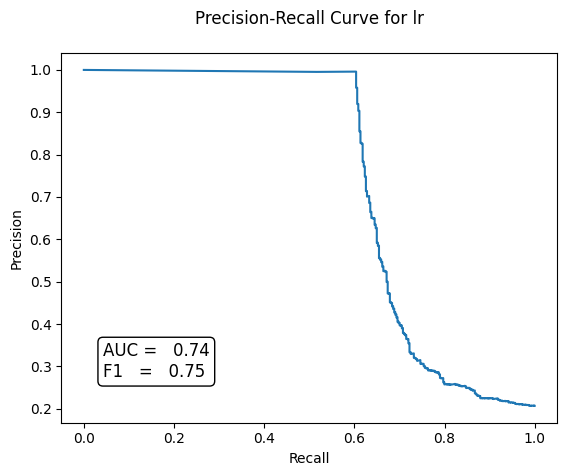

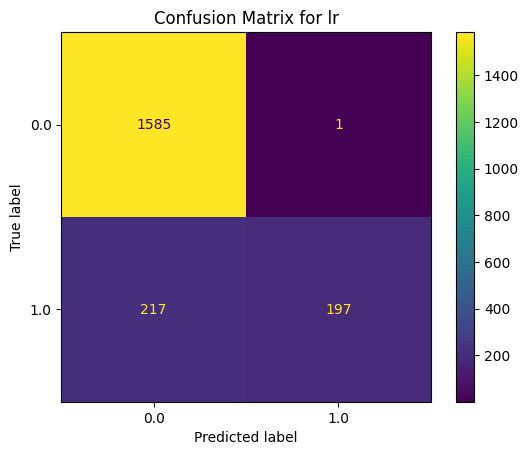

In [19]:
number_true = np.count_nonzero(y_test == 1)
print(number_true)

y_prob = svm_model.predict_proba(x_test)[:, 1]
y_pred = svm_model.predict(x_test)
plots.save_precision_recall_curve("lr", "test_file", y_test, y_prob)
plots.save_confusion_matrix("lr", "test_file", y_test, y_pred)